# Colab Setup

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 53kB/s 
     |████████████████████████████████| 61kB 26.7MB/s 
     |████████████████████████████████| 419kB 35.9MB/s 
     |████████████████████████████████| 3.0MB 46.1MB/s 


# New Section

In [0]:
import tensorflow as tf
import os
import numpy as np
print(tf.__version__)

2.0.0-alpha0


In [0]:
import pathlib
data_root = pathlib.Path("/content/drive/My Drive/Projects/Gesturec/data/leapGestRecog")
print(data_root)

/content/drive/My Drive/Projects/Gesturec/data/leapGestRecog


In [0]:
#for item in data_root.iterdir():
#  print(item)

In [0]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

20000

In [0]:
import IPython.display as display

In [0]:
#for n in range(3):
#  image_path = random.choice(all_image_paths)
#  display.display(display.Image(image_path))

In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [0]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

In [0]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [4, 8, 8, 8, 3, 7, 4, 3, 4, 9]


In [0]:
img_path = all_image_paths[0]
img_path

'/content/drive/My Drive/Projects/Gesturec/data/leapGestRecog/05_thumb/frame_07_05_0071.png'

In [0]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x8...


In [0]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(240, 640, 1)
<dtype: 'uint8'>


In [0]:
img_final = tf.image.resize(img_tensor, [224, 224])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(224, 224, 1)
0.008803463
0.982413


In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image /= 255.0  # normalize to [0,1] range

  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

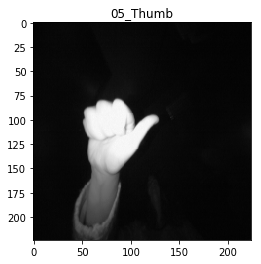

In [0]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.title(label_names[label].title())
print()

In [0]:
from sklearn.model_selection import train_test_split
train_image_paths,val_image_paths,train_image_labels,val_image_labesl = train_test_split(all_image_paths,all_image_labels,test_size=0.15)

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def tfdataset_build(image_path, image_labels, is_training=True, batch_size = 32):
  
  image_count = len(image_path)
  
  path_ds = tf.data.Dataset.from_tensor_slices(image_path)
  image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
  label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(image_labels, tf.int64))
  ds = tf.data.Dataset.zip((image_ds, label_ds))
  
  #if is_training:
  #  ds = ds.shuffle(buffer_size=image_count)
  ds = ds.repeat()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  
  return ds

In [0]:
train_ds = tfdataset_build(train_image_paths,train_image_labels)
val_ds = tfdataset_build(val_image_paths,val_image_labesl,is_training=False)

In [0]:
#Another way
#ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
#
## The tuples are unpacked into the positional arguments of the mapped function
#def load_and_preprocess_from_path_label(path, label):
#  return load_and_preprocess_image(path), label
#
#image_label_ds = ds.map(load_and_preprocess_from_path_label)
#image_label_ds

In [0]:
tinput = load_and_preprocess_image(train_image_paths[0])
tinput = tinput[None]

In [0]:
from tensorflow.keras import layers

In [0]:
class InitialLayer(layers.Layer):
  def __init__(self):
    super(InitialLayer, self).__init__()
    
    self.conv1 = layers.Conv2D(64,(7,7),strides=(2,2),padding='same')
    self.maxpool1 = layers.MaxPooling2D((3,3), strides=(2,2),padding='same')
    self.relu = layers.Activation('relu')
   
  def call(self,x):
    x = self.conv1(x)
    x = self.relu(x)

    x = self.maxpool1(x)
    return x

In [0]:
 class SkipLayer(layers.Layer):
  def __init__(self, kernels):
    super(SkipLayer, self).__init__()
    
    self.conv1 = layers.Conv2D(kernels,(3,3), padding = 'same')
    self.conv2 = layers.Conv2D(kernels,(3,3), padding = 'same')
    self.bn1 = layers.BatchNormalization()
    self.bn2 = layers.BatchNormalization()
    self.relu = layers.Activation('relu')
    
  def call(self,inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    
    x = layers.add([x,inputs])
    
    x = self.relu(x)
    return x

In [0]:
class BottleNeck(layers.Layer):
  def __init__(self, kernels):
    super(BottleNeck, self).__init__()
    
    self.conv1 = layers.Conv2D(kernels,(3,3), strides=(2,2), padding = 'same')
    self.conv2 = layers.Conv2D(kernels,(3,3), padding = 'same')
    self.conv3 = layers.Conv2D(kernels,(1,1) , strides = (2,2) , padding = 'same')
    self.bn1 = layers.BatchNormalization()
    self.bn2 = layers.BatchNormalization()
    self.relu = layers.Activation('relu')
    
  def call(self,inputs):
    #print(inputs.shape) #56,64
    x = self.conv1(inputs) #print(x.shape) # 28,128
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x) #print(x.shape) #28,128      
    x = self.bn2(x)
    x = self.relu(x)
    inputs = self.conv3(inputs)#print(inputs.shape) #28,128
    x = layers.add([x,inputs])
    
    x = self.relu(x)
    return x

In [0]:
class ANN(layers.Layer):
  def __init__(self, n_classes, blocks):
    super(ANN, self).__init__()
    self.blocks = blocks  
    self.n_classes = n_classes
    
    self.layer1 = [layers.Dense(units = self.blocks[i], activation='relu') for i in range(len(self.blocks))]
    self.layer2 = layers.Dense(self.n_classes, activation='sigmoid')
   
  def call(self,x):
    for i in range(len(self.blocks)):
      x = self.layer1[i](x)
     
    x = self.layer2(x)
    return x

In [0]:
@jjvbskv
class ResNet(tf.keras.Model):
  
  def __init__(self, blocks, n_classes):
    super(ResNet,self).__init__()
    self.n64 , self.n128 , self.n256, self.n512 = blocks
    self.n_classes = n_classes
    
    self.init_block = InitialLayer()
    self.block1 = [SkipLayer(64) for i in range(self.n64)]
    self.block2 = [SkipLayer(128) for i in range(self.n128)]
    self.block3 = [SkipLayer(256) for i in range(self.n256)]
    self.block4 = [SkipLayer(512) for i in range(self.n512)]
    
    self.bottle1 = BottleNeck(128)
    self.bottle2 = BottleNeck(256)
    self.bottle3 = BottleNeck(512)
    
    self.avgpool = layers.GlobalAveragePooling2D(name='avg_pool')
    self.flatten = layers.Flatten()
    
    self.op = ANN(10 , [1024,128])
    
  def call(self, x):
    #224
    x = self.init_block(x)
    #64
    for i in range(self.n64):
      x = self.block1[i](x)
    #128
    x = self.bottle1(x)
    
    for i in range(self.n128):
      x = self.block2[i](x)
    #256
    x = self.bottle2(x)
    
    for i in range(self.n256):
      x = self.block3[i](x)
    #512
    x = self.bottle3(x)
    for i in range(self.n512):
      x = self.block4[i](x)
     
    x = self.avgpool(x)
    x = self.flatten(x)
    
    x = self.op(x)
    
    
    return x

In [0]:
res = ResNet([3,3,5,2],10)

In [0]:
res.compile(optimizer=tf.keras.optimizers.Adam(),  # Optimizer
              # Loss function to minimize
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              # List of metrics to monitor
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [0]:
image_batch, label_batch = next(iter(train_ds))

In [0]:
op = res(image_batch)

In [0]:
op.shape

TensorShape([32, 10])

In [0]:
res.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
initial_layer (InitialLayer) multiple                  9472      
_________________________________________________________________
skip_layer (SkipLayer)       multiple                  74368     
_________________________________________________________________
skip_layer_1 (SkipLayer)     multiple                  74368     
_________________________________________________________________
skip_layer_2 (SkipLayer)     multiple                  74368     
_________________________________________________________________
skip_layer_3 (SkipLayer)     multiple                  296192    
_________________________________________________________________
skip_layer_4 (SkipLayer)     multiple                  296192    
_________________________________________________________________
skip_layer_5 (SkipLayer)     multiple                  2961

In [0]:
BATCH_SIZE = 32
steps_per_epoch=tf.math.ceil(len(val_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

94.0

In [0]:
??res.fit

In [0]:
res.fit(train_ds, epochs=10, steps_per_epoch=532,validation_data=val_ds,validation_steps=94)

W0514 16:26:01.077648 139797398722432 training_utils.py:1353] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 1/10
532/532 [==============================] - 461s 866ms/step - loss: 0.0488 - sparse_categorical_accuracy: 0.9854 - val_loss: 1.7287 - val_sparse_categorical_accuracy: 0.6396
Epoch 2/10
532/532 [==============================] - 131s 247ms/step - loss: 0.0288 - sparse_categorical_accuracy: 0.9908 - val_loss: 4.6264 - val_sparse_categorical_accuracy: 0.4794
Epoch 3/10
532/532 [==============================] - 133s 251ms/step - loss: 0.0319 - sparse_categorical_accuracy: 0.9899 - val_loss: 0.0459 - val_sparse_categorical_accuracy: 0.9840
Epoch 4/10
532/532 [==============================] - 133s 250ms/step - loss: 0.0102 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.1045 - val_sparse_categorical_accuracy: 0.9628
Epoch 5/10
532/532 [==============================] - 134s 252ms/step - loss: 0.0120 - sparse_categorical_accuracy: 0.9977 - val_loss: 1.4595 - val_sparse_categorical_accuracy: 0.7281
Epoch 6/10
532/532 [==============================] - 135s 253ms/step - loss: 0.

In [0]:
imgs, lbls = next(iter(val_ds))

In [0]:
ans = res(imgs)

In [0]:
ans.shape

TensorShape([32, 10])

In [0]:
tf.argmax(ans,1)

<tf.Tensor: id=96414, shape=(32,), dtype=int64, numpy=
array([5, 3, 0, 6, 4, 8, 1, 5, 1, 2, 8, 7, 6, 6, 5, 8, 3, 8, 7, 5, 9, 7,
       0, 1, 2, 8, 6, 1, 1, 3, 2, 8])>

In [0]:
lbls

<tf.Tensor: id=95332, shape=(32,), dtype=int64, numpy=
array([5, 3, 0, 6, 4, 8, 1, 5, 1, 2, 8, 7, 6, 6, 5, 8, 3, 8, 7, 5, 9, 7,
       0, 1, 2, 8, 6, 1, 1, 3, 2, 8])>

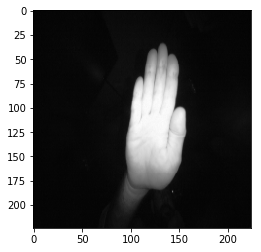

In [0]:
plt.imshow(imgs[2])

In [0]:
label_to_index

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

In [0]:
res.evaluate(val_ds,steps = 1000)

1000/1000 [==============================] - 134s 134ms/step - loss: 0.0100 - sparse_categorical_accuracy: 0.9983


[0.009983262796758709, 0.9983125]